In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/COMP6915 EA3/extraA3_Data.tsv'
data = pd.read_csv(file_path, sep='\t', header=None)

# Display the first few rows of the dataframe to understand its structure
data.head()

,0,1
0,CGTTATGACCAAAAAATAGATACTGTGACTGAACTCAATATATAGA...,1
1,TTTCTGGTTTAATATGCTTAGTTCAGGGAAGGTATATAAACAAGGA...,1
2,GTTTTATATCATAGGGCAATGTGGCGAGGAGTGTAGCCCTTTACAG...,1
3,ATCTGATAATTTTCGTATTTCAGAAGATTGATTTTATCGTTATTCT...,1
4,GATGGAGACCATAAAAATCTGTGGGGCAATCATTTAC,1


In [ ]:
# Correcting the column names and re-reading the dataset to properly identify the columns
data.columns = ['Sequence', 'Class']

# Check the corrected structure and class distribution
data.head(), data['Class'].value_counts()


(                                            Sequence  Class
 0  CGTTATGACCAAAAAATAGATACTGTGACTGAACTCAATATATAGA...      1
 1  TTTCTGGTTTAATATGCTTAGTTCAGGGAAGGTATATAAACAAGGA...      1
 2  GTTTTATATCATAGGGCAATGTGGCGAGGAGTGTAGCCCTTTACAG...      1
 3  ATCTGATAATTTTCGTATTTCAGAAGATTGATTTTATCGTTATTCT...      1
 4              GATGGAGACCATAAAAATCTGTGGGGCAATCATTTAC      1,
 0    653
 1    219
 Name: Class, dtype: int64)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Function to generate k-mer sequences from the original sequence
def generate_kmers(sequence, k=3):
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

# 1. k-mer Count Encoding for k=3, for a subset of the dataset
k = 3
data_subset = data['Sequence']
kmers_list = [' '.join(generate_kmers(seq, k=k)) for seq in data_subset]

vectorizer = CountVectorizer()
kmer_count_matrix = vectorizer.fit_transform(kmers_list)

# 2. Global Sequence Composition for the same subset
def global_composition(sequence):
    composition = np.array([sequence.count(nucleotide) for nucleotide in 'ACGT'])
    total = composition.sum()
    if total > 0:
        composition = composition / total  # Normalize to get proportions
    return composition

global_composition_matrix = np.array([global_composition(seq) for seq in data_subset])

# Output shapes for demonstration
kmer_count_matrix.shape, global_composition_matrix.shape


((872, 68), (872, 4))

In [ ]:
def bin_sequence(sequence, n_bins=5):
    """
    Divide the sequence into n_bins and calculate the frequency of each nucleotide (A, C, G, T) per bin.
    Returns a flattened array of these frequencies for the whole sequence.
    """
    # Calculate the approximate bin size for the sequence
    bin_size = len(sequence) // n_bins
    frequencies = []
    for i in range(n_bins):
        # Extract the bin
        start = i * bin_size
        end = (i + 1) * bin_size if i < n_bins - 1 else len(sequence)
        bin_seq = sequence[start:end]

        # Calculate and append the frequency of each nucleotide in this bin
        if len(bin_seq) > 0:
            frequencies.append([bin_seq.count(nucleotide) / len(bin_seq) for nucleotide in 'ACGT'])
        else:
            # If the bin is empty (due to rounding), append zeros
            frequencies.append([0, 0, 0, 0])

    # Flatten the list of frequencies to create a single feature vector per sequence
    return [freq for bin_freq in frequencies for freq in bin_freq]

# Apply the PWM with Binning encoding to the same subset of sequences
pwm_binning_matrix = np.array([bin_sequence(seq, n_bins=5) for seq in data_subset])

# Shape of the PWM with Binning feature matrix
pwm_binning_matrix.shape


(872, 20)

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import GradientBoostingClassifier

# Classifier and cross-validation setup
clf = GradientBoostingClassifier(random_state=42)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Function to perform cross-validation
def evaluate_model(X, y):
    scores = cross_validate(clf, X, y, cv=cv, scoring=scoring, return_train_score=False)
    return {k: v.mean() for k, v in scores.items()}

# Evaluate each encoding
y = data['Class']
results = {
    'k-mer Count Encoding': evaluate_model(kmer_count_matrix, y),
    'Global Sequence Composition': evaluate_model(global_composition_matrix, y),
    'PWM with Binning': evaluate_model(pwm_binning_matrix, y)
}

results


{'k-mer Count Encoding': {'fit_time': 0.652596378326416,
  'score_time': 0.008667659759521485,
  'test_accuracy': 0.7694749216300941,
  'test_precision': 0.6121031746031745,
  'test_recall': 0.23787878787878788,
  'test_f1': 0.33879621112273406},
 'Global Sequence Composition': {'fit_time': 0.17679152488708497,
  'score_time': 0.006151819229125976,
  'test_accuracy': 0.7339341692789969,
  'test_precision': 0.4549630924630924,
  'test_recall': 0.2510822510822511,
  'test_f1': 0.31900690141776733},
 'PWM with Binning': {'fit_time': 0.6165745496749878,
  'score_time': 0.008782744407653809,
  'test_accuracy': 0.762669801462905,
  'test_precision': 0.5552916038210156,
  'test_recall': 0.34285714285714286,
  'test_f1': 0.4186213081723918}}

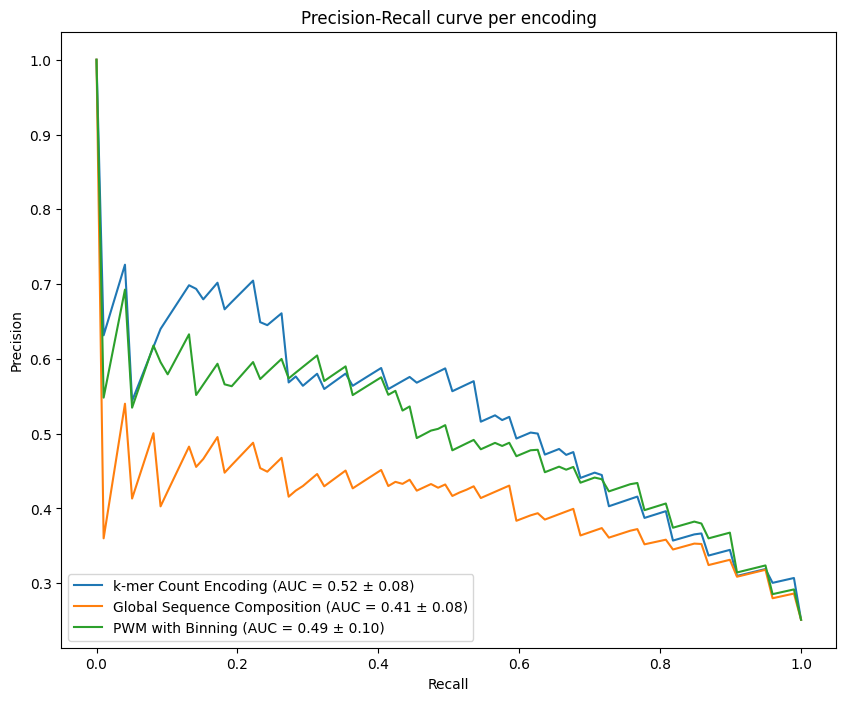

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import numpy as np


# Function to perform CV and collect precision-recall values
def compute_cv_precision_recall(X, y, clf, cv):
    tprs = []
    aucs = []
    mean_recall = np.linspace(0, 1, 100)

    for train, test in cv.split(X, y):
        y_test = label_binarize(y[test], classes=np.unique(y))
        if y_test.shape[1] == 1:  # Binary classification adjustment
            y_test = np.hstack([1 - y_test, y_test])
        classifier = OneVsRestClassifier(clf)
        classifier.fit(X[train], y[train])
        y_score = classifier.predict_proba(X[test])

        # Compute Precision-Recall and plot curve
        precision, recall, _ = precision_recall_curve(y_test[:, 1], y_score[:, 1])
        # Interpolate the precision-recall curve
        interp_precision = np.interp(mean_recall, recall[::-1], precision[::-1])
        interp_precision[0] = 1.0
        tprs.append(interp_precision)
        aucs.append(auc(mean_recall, interp_precision))

    # Average across folds
    mean_precision = np.mean(tprs, axis=0)
    mean_auc = auc(mean_recall, mean_precision)
    std_auc = np.std(aucs)
    return mean_recall, mean_precision, mean_auc, std_auc

# Classifier and CV setup
clf = GradientBoostingClassifier(random_state=42)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Compute precision-recall for each encoding
encodings = {
    'k-mer Count Encoding': kmer_count_matrix,
    'Global Sequence Composition': global_composition_matrix,
    'PWM with Binning': pwm_binning_matrix
}

plt.figure(figsize=(10, 8))

for name, X in encodings.items():
    mean_recall, mean_precision, mean_auc, std_auc = compute_cv_precision_recall(X, y, clf, cv)
    plt.plot(mean_recall, mean_precision, label=f'{name} (AUC = {mean_auc:.2f} ± {std_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve per encoding')
plt.legend(loc='lower left')

plt.show()


In [ ]:
from sklearn.metrics import f1_score, average_precision_score

def evaluate_metrics(X, y, clf, cv):
    f1_scores = []
    avg_precisions = []

    for train, test in cv.split(X, y):
        model = clf.fit(X[train], y[train])
        y_pred = model.predict(X[test])
        y_score = model.predict_proba(X[test])[:, 1]

        # Calculate metrics
        f1 = f1_score(y[test], y_pred)
        avg_precision = average_precision_score(y[test], y_score)

        f1_scores.append(f1)
        avg_precisions.append(avg_precision)

    # Calculate mean and standard deviation
    metrics = {
        'Mean F1-score': np.mean(f1_scores),
        'Std F1-score': np.std(f1_scores),
        'Mean Average Precision': np.mean(avg_precisions),
        'Std Average Precision': np.std(avg_precisions)
    }
    return metrics

# Classifier and CV setup
clf = GradientBoostingClassifier(random_state=42)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Datasets for each encoding
datasets = {
    'k-mer Count Encoding': kmer_count_matrix,
    'Global Sequence Composition': global_composition_matrix,
    'PWM with Binning': pwm_binning_matrix
}

results = {}

# Evaluate each encoding
for name, data in datasets.items():
    results[name] = evaluate_metrics(data, y, clf, cv)

# Convert results to DataFrame for easier viewing and analysis
results_df = pd.DataFrame(results).T
results_df['Best Encoding'] = results_df['Mean F1-score'] == results_df['Mean F1-score'].max()

print(results_df)


                             Mean F1-score  Std F1-score  \
k-mer Count Encoding              0.338796      0.079254   
Global Sequence Composition       0.319007      0.090822   
PWM with Binning                  0.418621      0.087335   

                             Mean Average Precision  Std Average Precision  \
k-mer Count Encoding                       0.537897               0.077071   
Global Sequence Composition                0.427537               0.080780   
PWM with Binning                           0.513006               0.099014   

                             Best Encoding  
k-mer Count Encoding                 False  
Global Sequence Composition          False  
PWM with Binning                      True  


In [ ]:
from sklearn.metrics import average_precision_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

# Assuming X_kmer, X_composition, X_pwm, and y are your datasets and labels

encodings = {
    'k-mer Count': kmer_count_matrix,
    'Global Composition': global_composition_matrix,
    'PWM Binning': pwm_binning_matrix
}

clf = GradientBoostingClassifier(random_state=42)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

results = {}

for encoding_name, X in encodings.items():
    ap_scores = []
    f1_scores = []

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        # Calculate metrics
        ap = average_precision_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        ap_scores.append(ap)
        f1_scores.append(f1)

    # Store results
    results[encoding_name] = {
        'AP Mean': np.mean(ap_scores),
        'AP Std': np.std(ap_scores),
        'F1 Mean': np.mean(f1_scores),
        'F1 Std': np.std(f1_scores)
    }

# Output the results
for encoding, scores in results.items():
    print(f"{encoding}: AP = {scores['AP Mean']:.3f} ± {scores['AP Std']:.3f}, F1 = {scores['F1 Mean']:.3f} ± {scores['F1 Std']:.3f}")


k-mer Count: AP = 0.342 ± 0.044, F1 = 0.339 ± 0.079
Global Composition: AP = 0.309 ± 0.047, F1 = 0.319 ± 0.091
PWM Binning: AP = 0.361 ± 0.061, F1 = 0.419 ± 0.087


New Test

In [ ]:
import numpy as np
from collections import Counter

# Function for nucleotide composition
def nucleotide_composition(seq):
    counter = Counter(seq)
    total = len(seq)
    return [counter[nuc] / total for nuc in "ATCG"]

# Function for k-mer composition
def kmer_composition(seq, k=3):
    kmers = [seq[i:i+k] for i in range(len(seq) - k + 1)]
    kmer_counts = Counter(kmers)
    # Normalize by the total number of k-mers to handle varying sequence lengths
    total_kmers = len(kmers)
    return {kmer: count / total_kmers for kmer, count in kmer_counts.items()}

# Example usage:
sequence_data = data.iloc[:, 0]  # Assuming the DNA sequences are in the first column

# Calculate nucleotide composition for each sequence
nucleotide_compositions = [nucleotide_composition(seq) for seq in sequence_data]

def dna_to_binary(seq):
    """Converts a DNA sequence into a binary representation."""
    binary_mapping = {'A': '00', 'T': '01', 'C': '10', 'G': '11'}
    return ''.join([binary_mapping[nuc] for nuc in seq])

def binary_features(binary_seq):
    """Calculates features from a binary sequence."""
    proportion_of_ones = binary_seq.count('1') / len(binary_seq)
    binary_length = len(binary_seq)
    return proportion_of_ones, binary_length

# Apply the binary encoding strategy to the first few sequences as an example
binary_encoded_sequences = [dna_to_binary(seq) for seq in sequence_data[:5]]
binary_features_list = [binary_features(seq) for seq in binary_encoded_sequences]


k = 2  # Example k value
example_seq = sequence_data.iloc[0]
example_kmer_composition = kmer_composition(example_seq, k=k)

# Output the nucleotide composition for the first sequence and k-mer composition for an example
nucleotide_compositions[0], example_kmer_composition

# Display the features for the first few sequences
binary_features_list

[(0.4050632911392405, 316),
 (0.4789156626506024, 332),
 (0.5409836065573771, 122),
 (0.41150442477876104, 226),
 (0.44594594594594594, 74)]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

X = data.iloc[:, 0]  # DNA sequences
y = data.iloc[:, 1]  # Target variable

# Function to convert sequences into k-mers
def get_kmers(seq, k=2):
    return [seq[i:i+k] for i in range(len(seq)-k+1)]

# Convert each sequence in the dataset into a list of k-mers
X_kmers = [" ".join(get_kmers(seq, k=3)) for seq in X]

# Use CountVectorizer to convert the list of k-mers into a matrix of k-mer frequencies
vectorizer = CountVectorizer()
X_kmer_encoded = vectorizer.fit_transform(X_kmers).toarray()


In [ ]:
def dna_to_binary(seq):
    binary_mapping = {'A': '00', 'T': '01', 'C': '10', 'G': '11', 'N': '00'}
    return ''.join([binary_mapping[nuc] for nuc in seq])

def binary_features(binary_seq):
    proportion_of_ones = binary_seq.count('1') / len(binary_seq)
    binary_length = len(binary_seq)
    return [proportion_of_ones, binary_length]

# Convert DNA sequences to binary and then to features
X_binary_encoded = np.array([binary_features(dna_to_binary(seq)) for seq in X])


In [ ]:
# Function for nucleotide composition
def nucleotide_composition(seq):
    counter = Counter(seq)
    total = len(seq)
    return [counter[nuc] / total for nuc in "ATCG"]

# Encode sequences
X_neucleotide_encoded = np.array([nucleotide_composition(seq) for seq in X])

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

def evaluate_model(X, y):
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
    cv = StratifiedKFold(n_splits=10)
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    return scores.mean(), scores.std()

# Evaluate model for K-mer encoding
mean_accuracy, std_dev = evaluate_model(X_kmer_encoded, y)
print(f"K-mer Encoding: Accuracy = {mean_accuracy:.4f} ± {std_dev:.4f}")

# Evaluate model for Binary encoding
mean_accuracy, std_dev = evaluate_model(X_binary_encoded, y)
print(f"Binary Encoding: Accuracy = {mean_accuracy:.4f} ± {std_dev:.4f}")

# Evaluate model for Nucleotide composition
mean_accuracy, std_dev = evaluate_model(X_neucleotide_encoded, y)
print(f"Nucleotide Composition: Accuracy = {mean_accuracy:.4f} ± {std_dev:.4f}")


K-mer Encoding: Accuracy = 0.7327 ± 0.0458
Binary Encoding: Accuracy = 0.7328 ± 0.0112
Nucleotide Composition: Accuracy = 0.7339 ± 0.0353


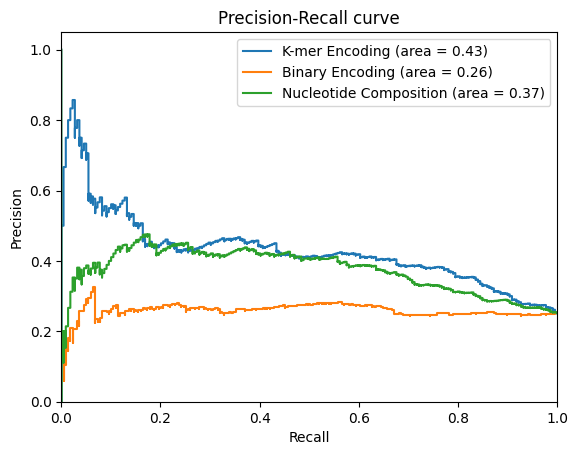

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

def plot_precision_recall_curve(X, y, encoding_label):
    # Initialize cross-validation and classifier
    cv = StratifiedKFold(n_splits=10)
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

    # Variables to hold combined results
    y_real = []
    y_proba = []

    # Manually iterate through cross-validation folds
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf.fit(X_train, y_train)
        probas_ = clf.predict_proba(X_test)

        # Extend the real and predicted probabilities for this fold
        y_real.extend(y_test)
        y_proba.extend(probas_[:, 1])

    # Calculate precision and recall values
    precision, recall, _ = precision_recall_curve(y_real, y_proba)

    # Calculate area under the precision-recall curve
    pr_auc = auc(recall, precision)

    # Plotting
    plt.step(recall, precision, where='post', label=f'{encoding_label} (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve')
    plt.legend(loc="upper right")

# Convert y to a numpy array if it's not already, to facilitate indexing
y = np.array(y)

# Generate precision-recall curve for K-mer Encoding
plot_precision_recall_curve(X_kmer_encoded, y, 'K-mer Encoding')

# Generate precision-recall curve for Binary Encoding
plot_precision_recall_curve(X_binary_encoded, y, 'Binary Encoding')

# Generate precision-recall curve for Nucleotide Composition
plot_precision_recall_curve(X_neucleotide_encoded, y, 'Nucleotide Composition')

plt.show()


In [ ]:
from sklearn.metrics import average_precision_score, f1_score
import numpy as np

def calculate_scores(X, y):
    cv = StratifiedKFold(n_splits=10)
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

    average_precisions = []
    f1_scores = []

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_score = clf.predict_proba(X_test)[:, 1]

        # Calculate and store the scores
        average_precisions.append(average_precision_score(y_test, y_score))
        f1_scores.append(f1_score(y_test, y_pred))

    # Calculate mean and standard deviation for each metric
    mean_ap = np.mean(average_precisions)
    std_ap = np.std(average_precisions)
    mean_f1 = np.mean(f1_scores)
    std_f1 = np.std(f1_scores)

    return mean_ap, std_ap, mean_f1, std_f1

# Convert y to a numpy array if it's not already, for consistency
y = np.array(y)

# K-mer Encoding
mean_ap, std_ap, mean_f1, std_f1 = calculate_scores(X_kmer_encoded, y)
print(f"K-mer Encoding: Average Precision = {mean_ap:.4f} ± {std_ap:.4f}, F1-score = {mean_f1:.4f} ± {std_f1:.4f}")

# Binary Encoding
mean_ap, std_ap, mean_f1, std_f1 = calculate_scores(X_binary_encoded, y)
print(f"Binary Encoding: Average Precision = {mean_ap:.4f} ± {std_ap:.4f}, F1-score = {mean_f1:.4f} ± {std_f1:.4f}")

# Nucleotide Composition
mean_ap, std_ap, mean_f1, std_f1 = calculate_scores(X_neucleotide_encoded, y)
print(f"Nucleotide Composition: Average Precision = {mean_ap:.4f} ± {std_ap:.4f}, F1-score = {mean_f1:.4f} ± {std_f1:.4f}")

K-mer Encoding: Average Precision = 0.4606 ± 0.0763, F1-score = 0.3916 ± 0.0852
Binary Encoding: Average Precision = 0.2845 ± 0.0298, F1-score = 0.0247 ± 0.0377
Nucleotide Composition: Average Precision = 0.4201 ± 0.0714, F1-score = 0.2911 ± 0.1250


New Test 2

In [ ]:
# Let's first read the uploaded dataset to understand its structure and content
import pandas as pd

# Load the dataset
dataset_path = '/content/drive/MyDrive/Colab Notebooks/COMP6915 EA3/extraA3_Data.tsv'
data = pd.read_csv(dataset_path, sep='\t')  # Assuming it's tab-separated given the .tsv extension

# Display the first few rows of the dataset to get an overview
data.head()


,CGTTATGACCAAAAAATAGATACTGTGACTGAACTCAATATATAGATAATTACCATATACAGACGGTTTTATTTATGCCATTGTTATGTTCAGTTGACTGCGTACTAAATAATATATATGGACACCGACTAAATTCAAGTTGGTGACATATTTTCTGA,1
0,TTTCTGGTTTAATATGCTTAGTTCAGGGAAGGTATATAAACAAGGA...,1
1,GTTTTATATCATAGGGCAATGTGGCGAGGAGTGTAGCCCTTTACAG...,1
2,ATCTGATAATTTTCGTATTTCAGAAGATTGATTTTATCGTTATTCT...,1
3,GATGGAGACCATAAAAATCTGTGGGGCAATCATTTAC,1
4,CCGCAGGTGAATACAACGTTGAGCGATAAACGTTGTGCTCCATAAT...,1


In [ ]:
from collections import Counter
import numpy as np

# Define the k-mer size
k = 3

def generate_kmers(sequence, k):
    """Generate k-mers from a given sequence."""
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

def kmer_encoding(data, k):
    """Encode the dataset using k-mer encoding."""
    # Generate k-mers for all sequences
    all_kmers = []
    for seq in data.iloc[:, 0]:
        kmers = generate_kmers(seq, k)
        all_kmers.extend(kmers)

    # Get the unique k-mers to define the feature space
    unique_kmers = list(set(all_kmers))

    # Initialize a matrix to hold the k-mer counts for each sequence
    encoded_features = np.zeros((len(data), len(unique_kmers)))

    # Fill in the matrix with k-mer counts
    for i, seq in enumerate(data.iloc[:, 0]):
        kmers = generate_kmers(seq, k)
        kmers_count = Counter(kmers)
        for j, kmer in enumerate(unique_kmers):
            if kmer in kmers_count:
                encoded_features[i, j] = kmers_count[kmer]

    return pd.DataFrame(encoded_features, columns=unique_kmers)

# Apply k-mer encoding to the dataset
kmer_encoded_data = kmer_encoding(data, k)

# Display the shape of the encoded data to understand its dimensionality
kmer_encoded_data.shape


(871, 68)

In [ ]:
def nucleotide_proportions(sequence):
    """Calculate the proportions of A, C, G, T, and N in the sequence."""
    # Count each nucleotide
    counts = Counter(sequence)
    total_length = len(sequence)
    # Calculate proportions
    proportions = [counts.get(nucleotide, 0) / total_length for nucleotide in ['A', 'C', 'G', 'T', 'N']]
    return proportions

# Apply this encoding to the dataset
binary_encoded_data = pd.DataFrame([nucleotide_proportions(seq) for seq in data.iloc[:, 0]],
                                   columns=['A', 'C', 'G', 'T', 'N'])

binary_encoded_data.head()


,A,C,G,T,N
0,0.234940,0.180723,0.192771,0.391566,0.0
1,0.213115,0.147541,0.295082,0.344262,0.0
2,0.318584,0.097345,0.141593,0.442478,0.0
3,0.351351,0.162162,0.243243,0.243243,0.0
4,0.241176,0.158824,0.235294,0.364706,0.0


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# We need to join the k-mers into a single string per sequence, as TfidfVectorizer expects text input
def join_kmers(sequence, k):
    """Generate k-mers and join them into a single string."""
    kmers = generate_kmers(sequence, k)
    return ' '.join(kmers)

# Convert each sequence to a string of 4-mers
kmers_as_strings = [join_kmers(seq, k) for seq in data.iloc[:, 0]]

# Initialize and fit the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w{'+str(k)+'}')
tfidf_encoded_data = tfidf_vectorizer.fit_transform(kmers_as_strings)

# Convert the TF-IDF sparse matrix to a DataFrame for easier viewing
tfidf_encoded_df = pd.DataFrame(tfidf_encoded_data.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

tfidf_encoded_df.shape, tfidf_encoded_df.head()


((871, 68),
         aaa       aac       aag       aat       aca       acc       acg  \
 0  0.137533  0.071064  0.151917  0.126505  0.037707  0.000000  0.000000   
 1  0.000000  0.000000  0.000000  0.077323  0.092189  0.000000  0.000000   
 2  0.258986  0.000000  0.095358  0.119111  0.000000  0.000000  0.000000   
 3  0.389854  0.000000  0.000000  0.239064  0.000000  0.152722  0.000000   
 4  0.034146  0.105862  0.075436  0.094226  0.112341  0.080259  0.085535   
 
         act       aga       agc  ...       tct       tga       tgc       tgg  \
 0  0.080124  0.039002  0.038813  ...  0.119892  0.066946  0.076050  0.073371   
 1  0.000000  0.000000  0.094893  ...  0.000000  0.000000  0.000000  0.179385   
 2  0.000000  0.195849  0.048725  ...  0.250852  0.084044  0.047736  0.046055   
 3  0.000000  0.147406  0.000000  ...  0.151044  0.000000  0.000000  0.277307   
 4  0.000000  0.038733  0.038546  ...  0.000000  0.166213  0.151053  0.036433   
 
         tgt  tnn       tta       ttc     

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder

# Prepare the labels
labels = data.iloc[:, 1].values

# Ensure labels are encoded properly
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Initialize the classifier
gb_classifier = GradientBoostingClassifier(random_state=42)

# Initialize 10-fold stratified CV
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define a function to perform cross-validation and return mean accuracy
def perform_cross_validation(X, y, classifier, cv):
    # Compute the 10-fold CV accuracy
    accuracies = cross_val_score(classifier, X, y, cv=cv, scoring='accuracy')
    return accuracies.mean()

# Perform CV for each encoding
kmer_cv_accuracy = perform_cross_validation(kmer_encoded_data, encoded_labels, gb_classifier, cv)
binary_cv_accuracy = perform_cross_validation(binary_encoded_data, encoded_labels, gb_classifier, cv)
tfidf_cv_accuracy = perform_cross_validation(tfidf_encoded_df, encoded_labels, gb_classifier, cv)

print(f"K-mer Encoding: Accuracy = {kmer_cv_accuracy:.4f}")
print(f"Binary Encoding: Accuracy = {binary_cv_accuracy:.4f}")
print(f"TF-IDF Encoding: Accuracy = {tfidf_cv_accuracy:.4f}")


K-mer Encoding: Accuracy = 0.7692
Binary Encoding: Accuracy = 0.7416
TF-IDF Encoding: Accuracy = 0.7532


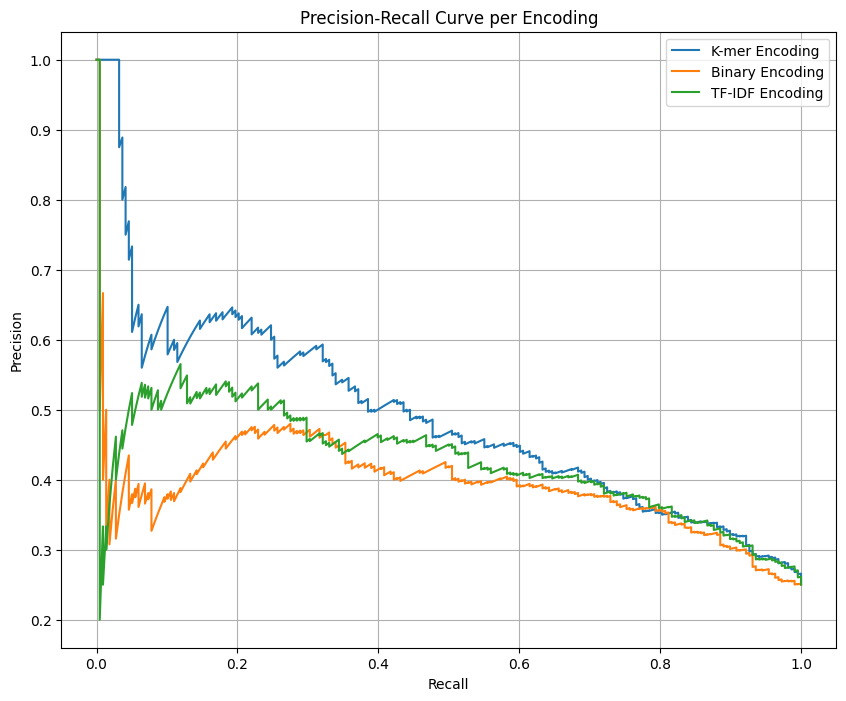

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

# Define a function to perform CV and return precision-recall values
def cv_precision_recall(X, y, classifier, cv):
    # Generate cross-validated estimates for each input data point
    y_scores = cross_val_predict(classifier, X, y, cv=cv, method='predict_proba')

    # Keep probabilities for the positive class only
    y_scores = y_scores[:, 1]

    # Calculate precision and recall for all thresholds
    precision, recall, thresholds = precision_recall_curve(y, y_scores)

    return precision, recall

# Collect precision-recall for each encoding
kmer_precision, kmer_recall = cv_precision_recall(kmer_encoded_data, encoded_labels, gb_classifier, cv)
binary_precision, binary_recall = cv_precision_recall(binary_encoded_data, encoded_labels, gb_classifier, cv)
tfidf_precision, tfidf_recall = cv_precision_recall(tfidf_encoded_df, encoded_labels, gb_classifier, cv)

# Plot the precision-recall curves
plt.figure(figsize=(10, 8))
plt.plot(kmer_recall, kmer_precision, label='K-mer Encoding')
plt.plot(binary_recall, binary_precision, label='Binary Encoding')
plt.plot(tfidf_recall, tfidf_precision, label='TF-IDF Encoding')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve per Encoding')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import average_precision_score, f1_score
from sklearn.model_selection import StratifiedKFold

# Initialize a new 10-fold stratified CV
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define a function to compute scores across CV folds
def compute_cv_scores(X, y, classifier, cv):
    avg_precision_scores = []
    f1_scores = []

    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        y_score = classifier.predict_proba(X_test)[:, 1]

        avg_precision = average_precision_score(y_test, y_score)
        f1 = f1_score(y_test, y_pred)

        avg_precision_scores.append(avg_precision)
        f1_scores.append(f1)

    return avg_precision_scores, f1_scores

# Compute scores for each encoding
kmer_avg_precisions, kmer_f1s = compute_cv_scores(kmer_encoded_data, encoded_labels, gb_classifier, cv)
binary_avg_precisions, binary_f1s = compute_cv_scores(binary_encoded_data, encoded_labels, gb_classifier, cv)
tfidf_avg_precisions, tfidf_f1s = compute_cv_scores(tfidf_encoded_df, encoded_labels, gb_classifier, cv)

# Calculate mean and standard deviation
scores_summary = {
    'Encoding': ['K-mer', 'Binary', 'TF-IDF'],
    'Mean Average Precision': [np.mean(kmer_avg_precisions), np.mean(binary_avg_precisions), np.mean(tfidf_avg_precisions)],
    'STD Average Precision': [np.std(kmer_avg_precisions), np.std(binary_avg_precisions), np.std(tfidf_avg_precisions)],
    'Mean F1-Score': [np.mean(kmer_f1s), np.mean(binary_f1s), np.mean(tfidf_f1s)],
    'STD F1-Score': [np.std(kmer_f1s), np.std(binary_f1s), np.std(tfidf_f1s)]
}

pd.DataFrame(scores_summary)


,Encoding,Mean Average Precision,STD Average Precision,Mean F1-Score,STD F1-Score
0,K-mer,0.521574,0.078617,0.383240,0.084470
1,Binary,0.429881,0.080194,0.313703,0.080223
2,TF-IDF,0.466450,0.071421,0.341973,0.088757
